In [1]:
from copy import deepcopy
import numpy as np
from numpy.linalg import norm
import scipy.ndimage as ndi
from aquapointer.analog.utils import detuning_scale_utils as dsu
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
from aquapointer.slicing import density_file_to_grid, density_slices_by_plane_and_offsets, density_slices_by_planes, density_origin, density_point_boundaries
import matplotlib.pyplot as plt

In [2]:
grid = density_file_to_grid("../data/3D-RISM_densities/1NNC/prot_3drism.O.1.dx")

In [3]:
print(density_origin(grid))
print(density_point_boundaries(grid))

[ 6.694 -3.659 41.76 ]
[46.694 36.341 81.76 ]


In [4]:
points = np.array([[0, 0, 10], [1, 0, 10], [0, 1, 10]]) + np.array([density_origin(grid)] * 3)
canvases = density_slices_by_plane_and_offsets(grid, points=points, offsets=[10, 20])

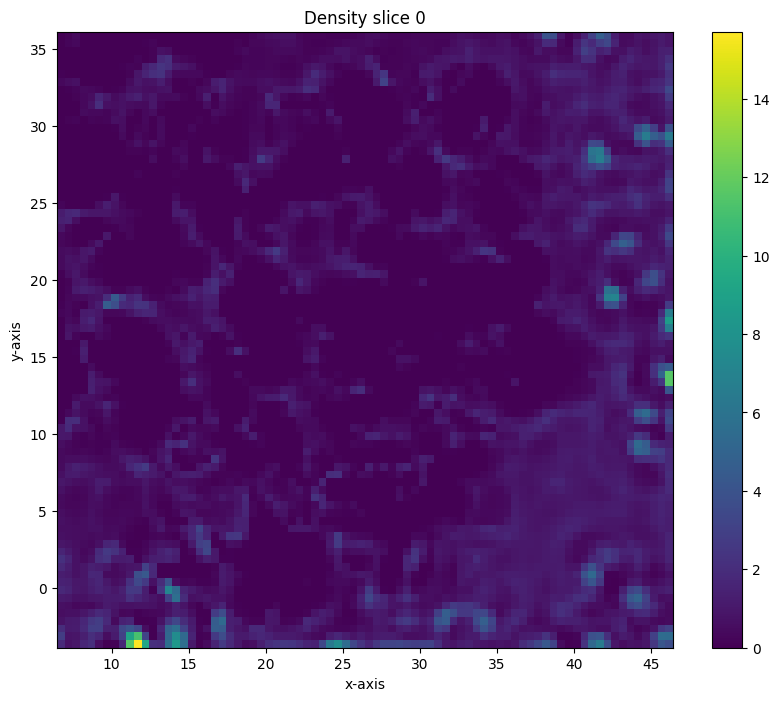

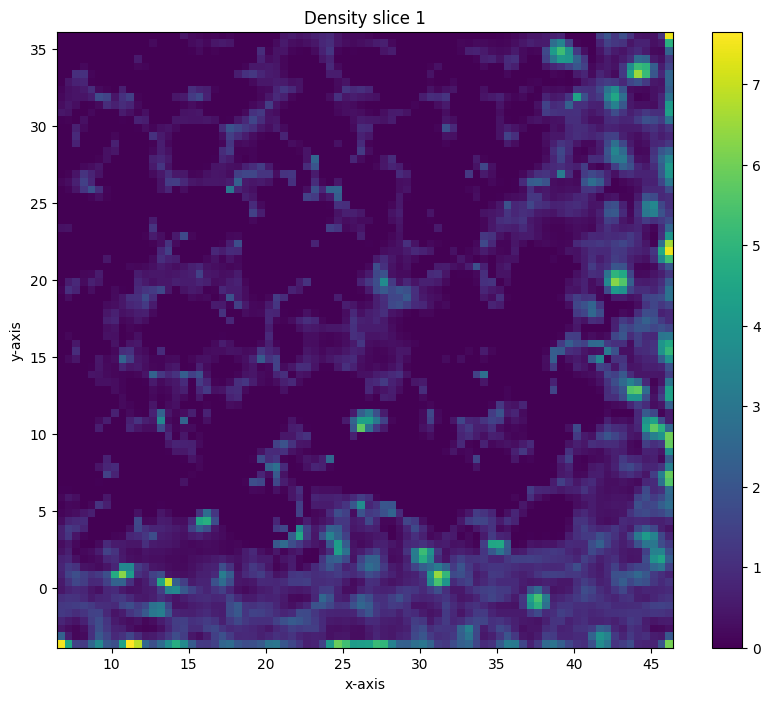

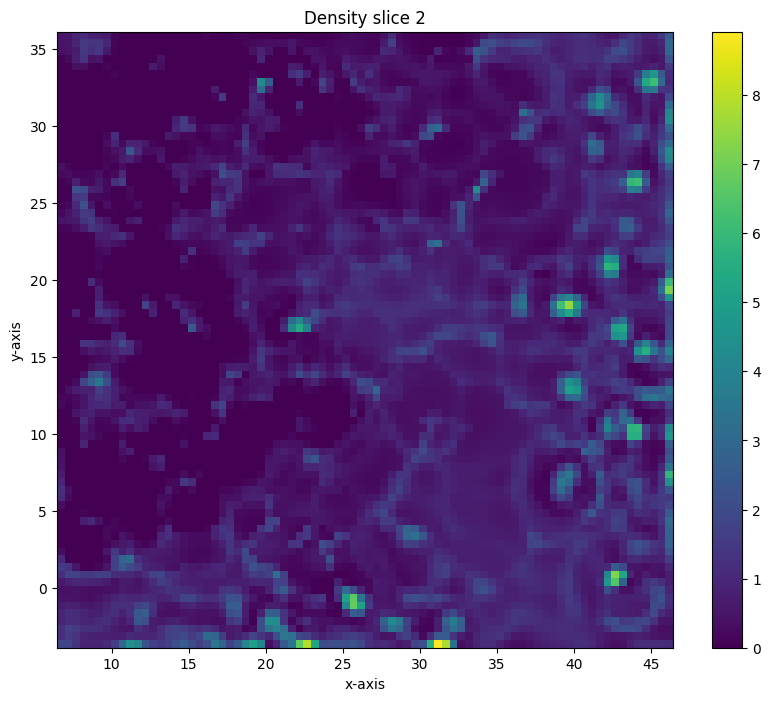

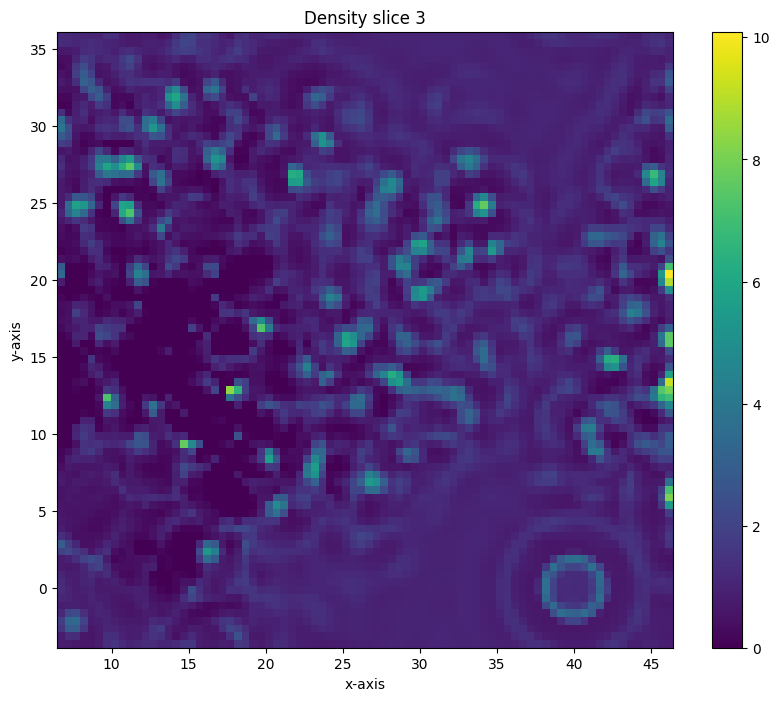

In [5]:
for c, canvas in enumerate(canvases):
    canvas.draw(title=f"Density slice {c}")

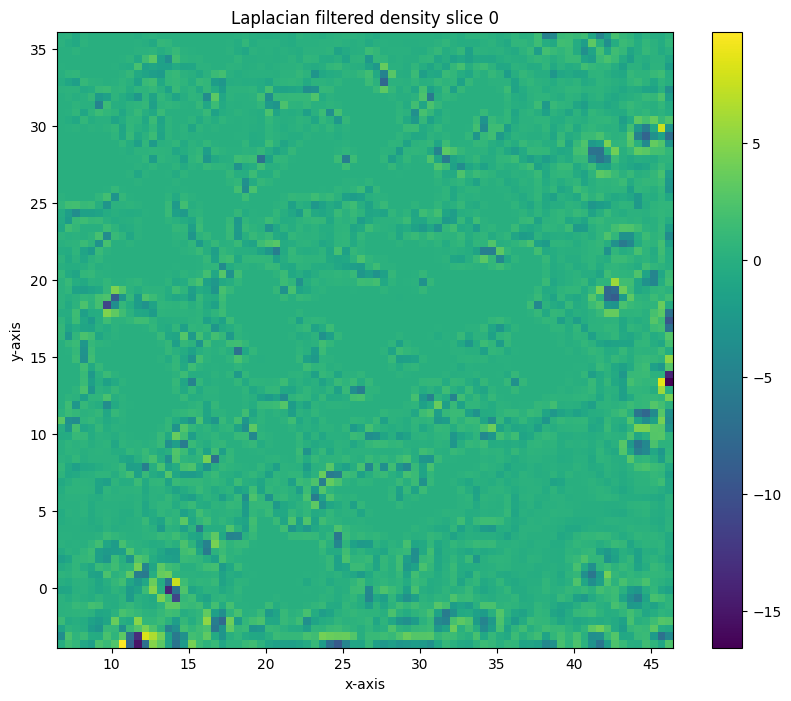

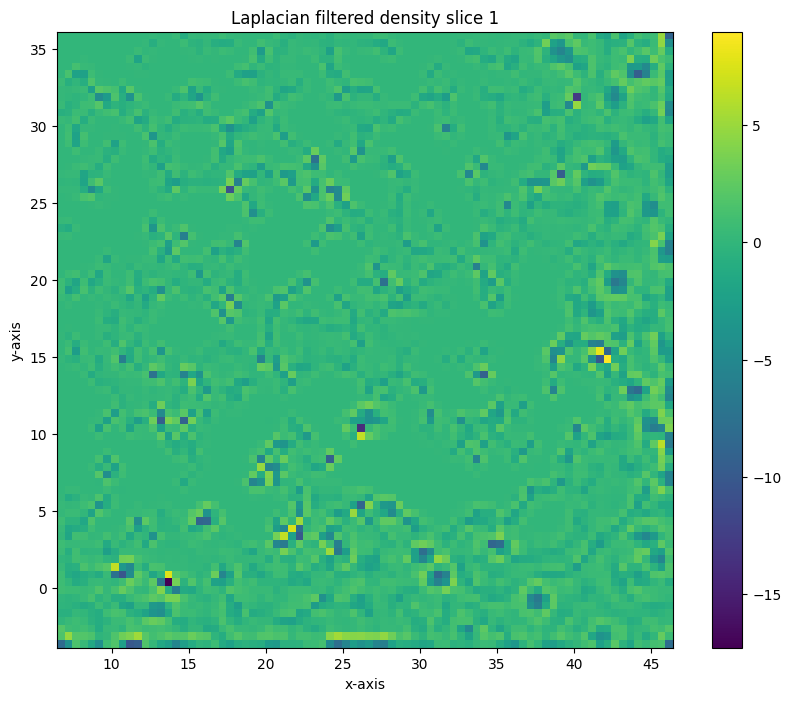

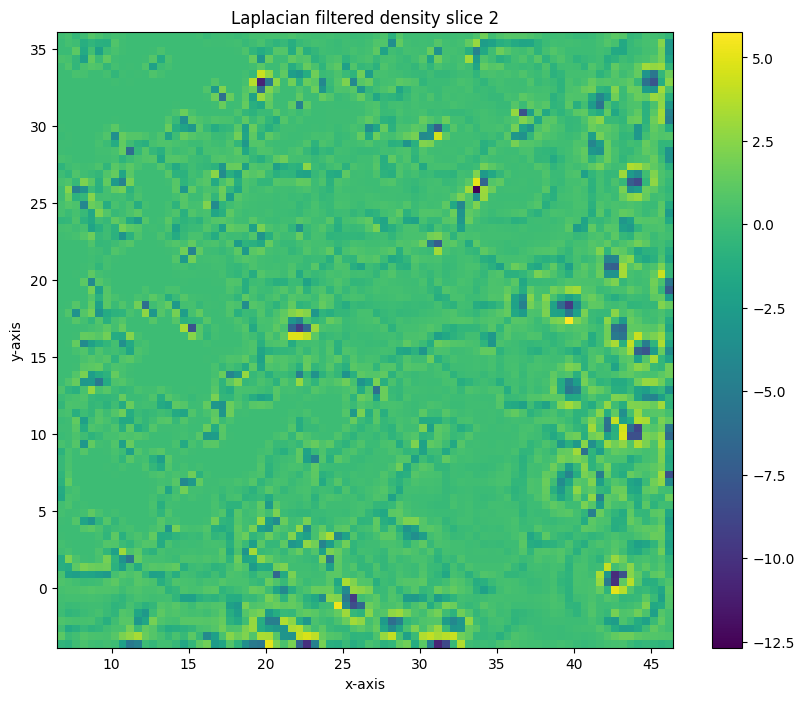

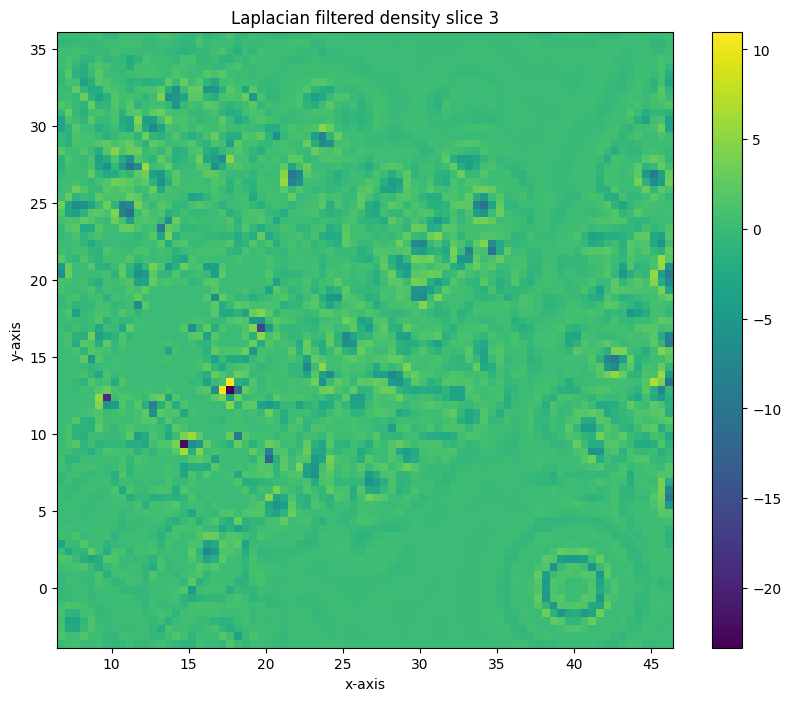

In [6]:
for c, canvas in enumerate(canvases):
    filtered = deepcopy(canvas)
    filtered.filter_density(filter_settings={"filter_function": ndi.laplace})
    filtered.draw(title=f"Laplacian filtered density slice {c}")

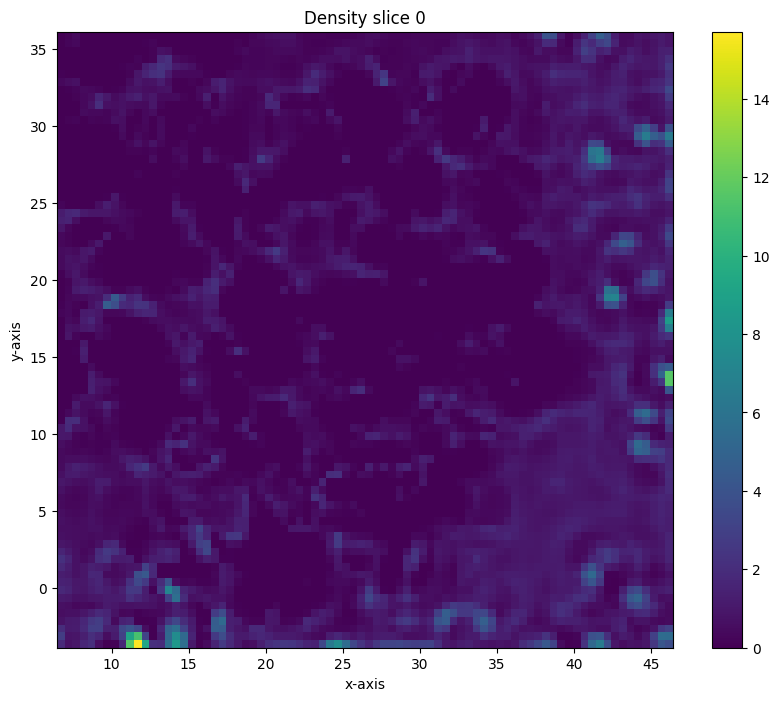

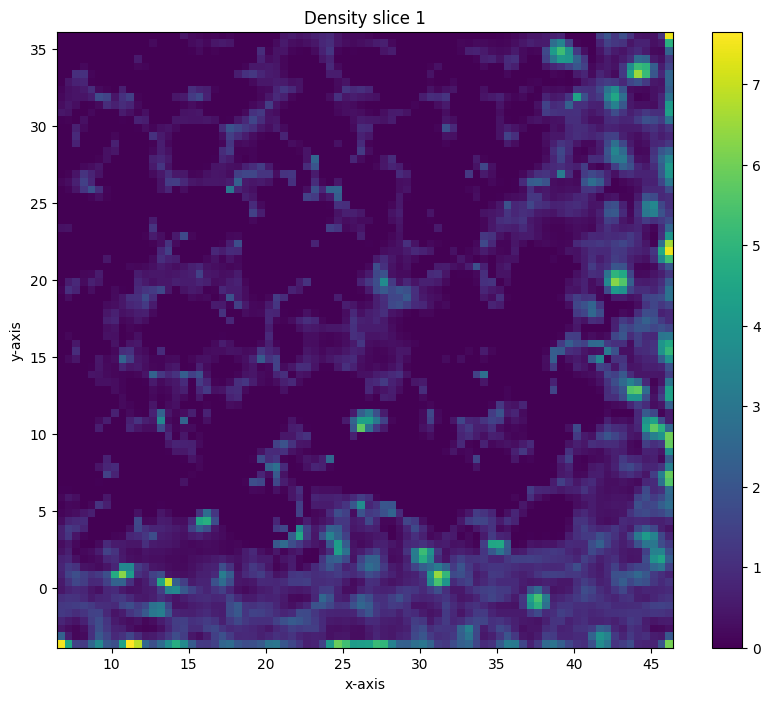

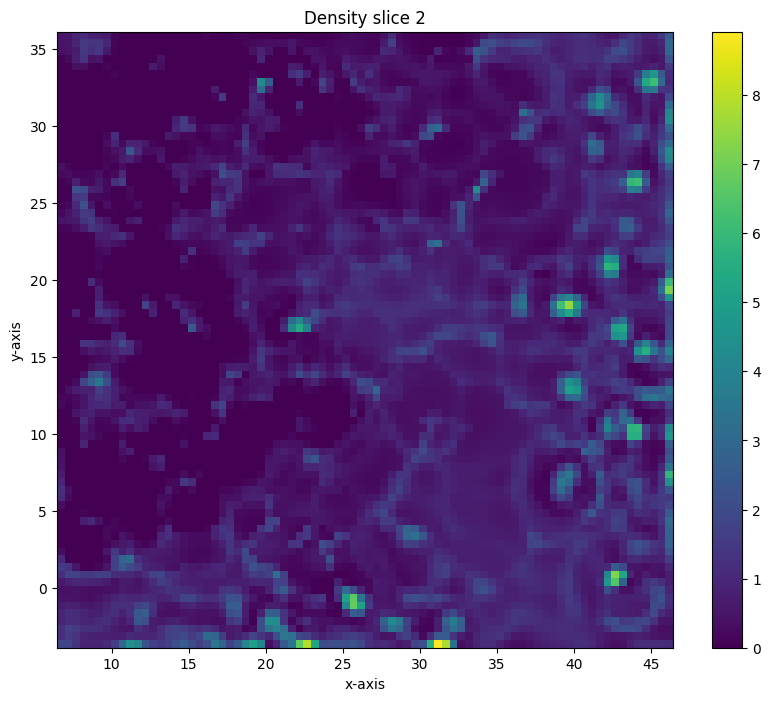

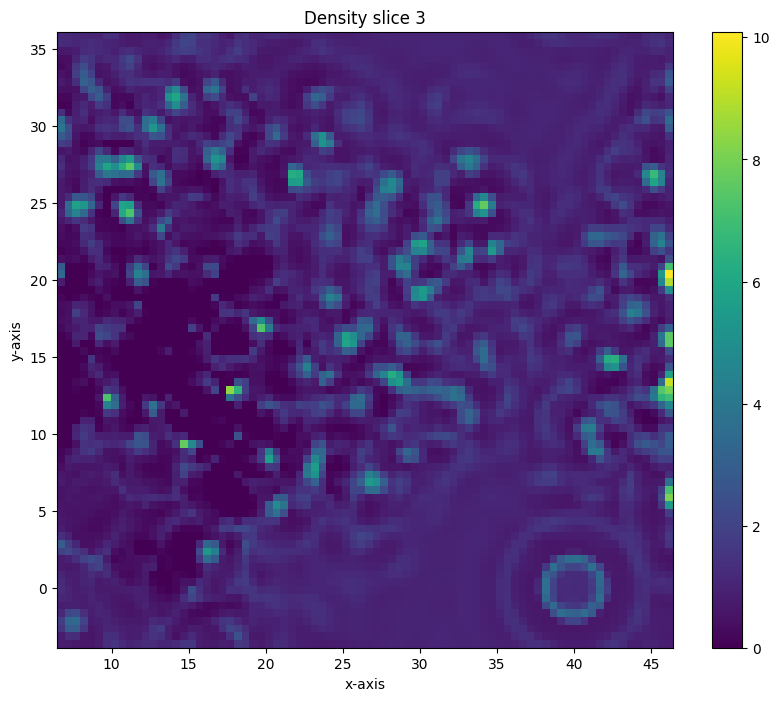

In [7]:
cropped_canvases = deepcopy(canvases)

for c, canvas in enumerate(canvases):
    cropped = deepcopy(canvas)
    cropped.crop_canvas((40, 40), (20, 20))
    canvas.plotting_objects(title=f"Density slice {c}")

In [7]:
og = density_origin(grid)
slicing_planes = [(og + np.array([5, 10, 8]), np.array([0, 1, 1])), (og + np.array([15, 16, 20]), np.array([0, 1, 1])), (og + np.array([25, 22, 32]), np.array([0, 1, 1]))]
canvases_1nnc = density_slices_by_planes(grid, slicing_planes)

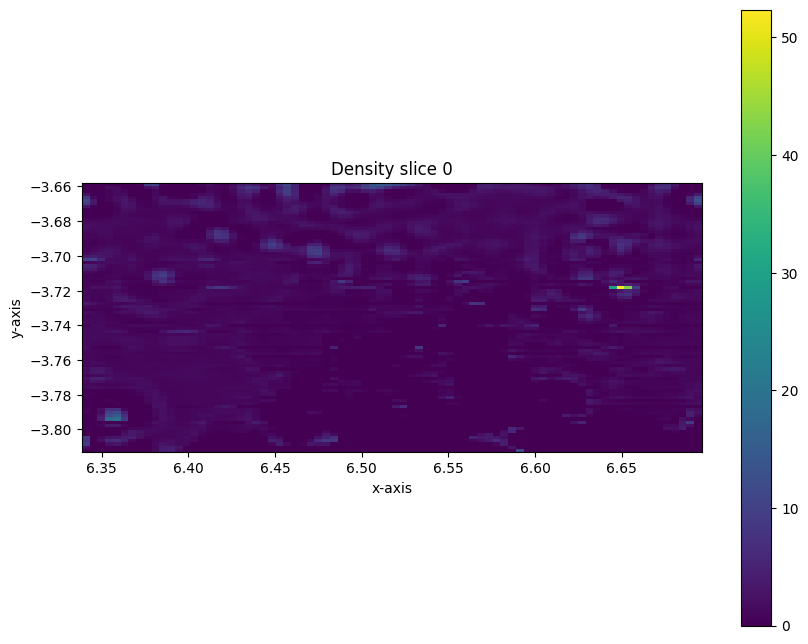

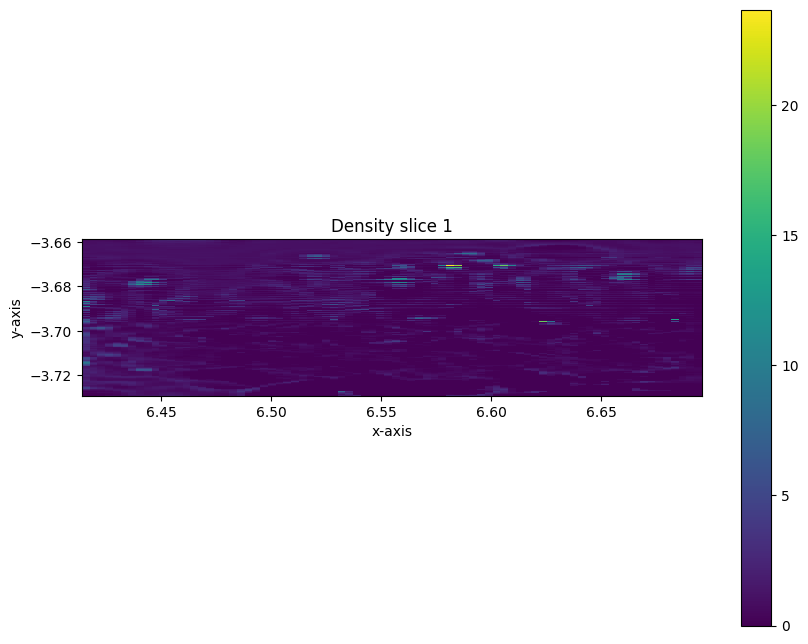

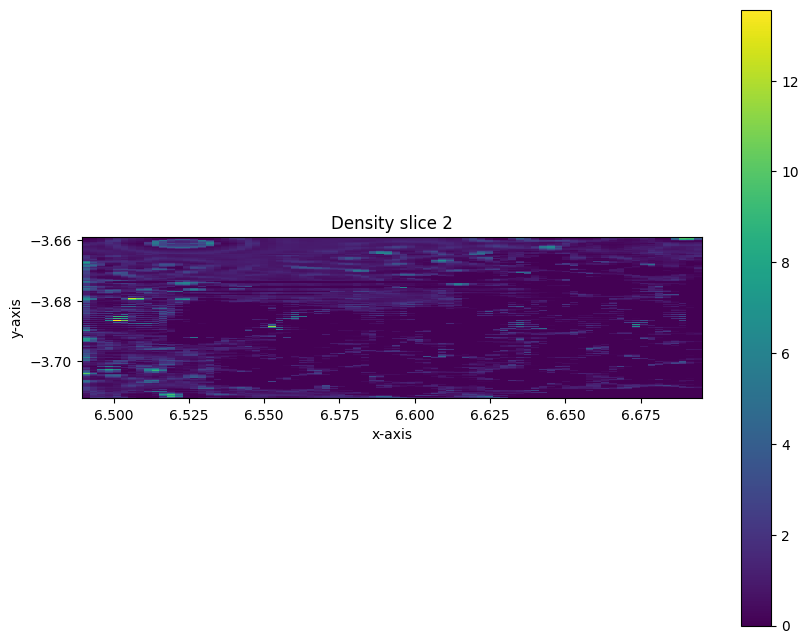

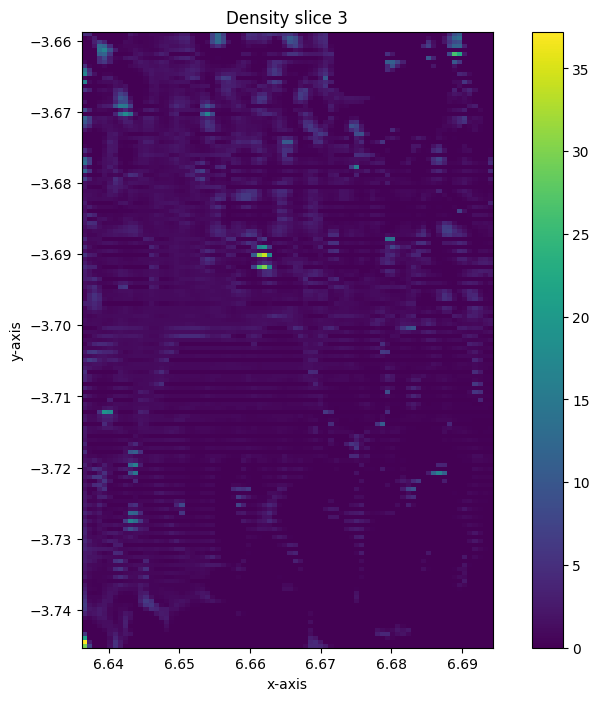

In [8]:
for c, canvas in enumerate(canvases_1nnc):
    canvas.plotting_objects(title=f"Density slice {c}")

In [ ]:
canvases_1nnc[0].canvas_rotation

In [8]:
grid_bd = density_file_to_grid("../data/3D-RISM_densities/bromoD/prot_3drism.O.1.dx")

In [9]:
print(density_origin(grid_bd))
print(density_point_boundaries(grid_bd))

[101.906 -26.182 -20.756]
[141.906  13.818  19.244]


In [ ]:
points = np.array([[0, 5, 0], [1, 5, 0], [0, 5, -1]]) + np.array([density_origin(grid_bd)] * 3)
canvases_bd = density_slices_by_plane_and_offsets(grid, points=points, offsets=np.linspace(5, 30, 6, dtype=int))

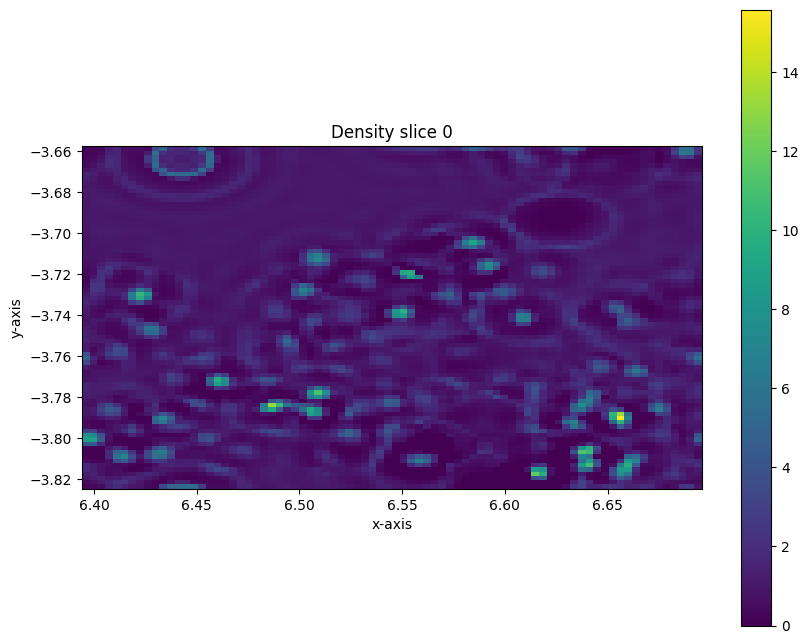

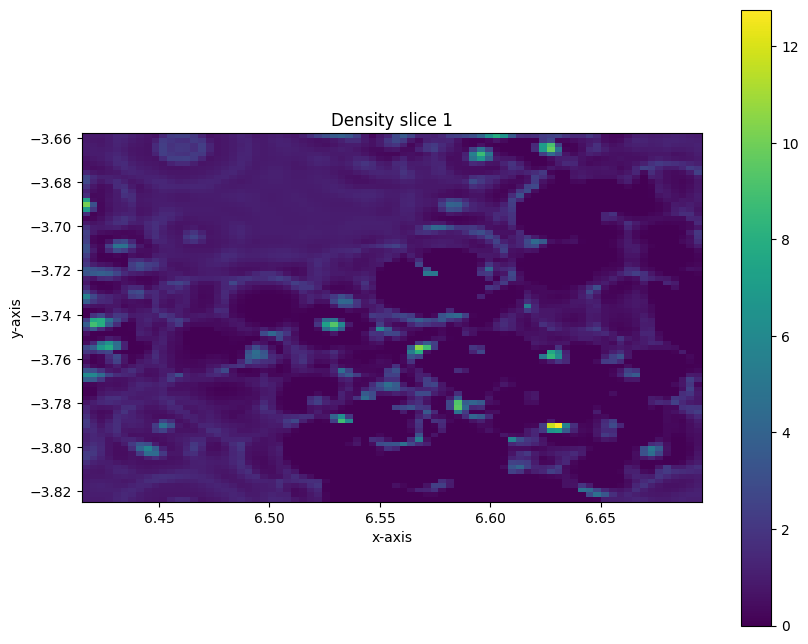

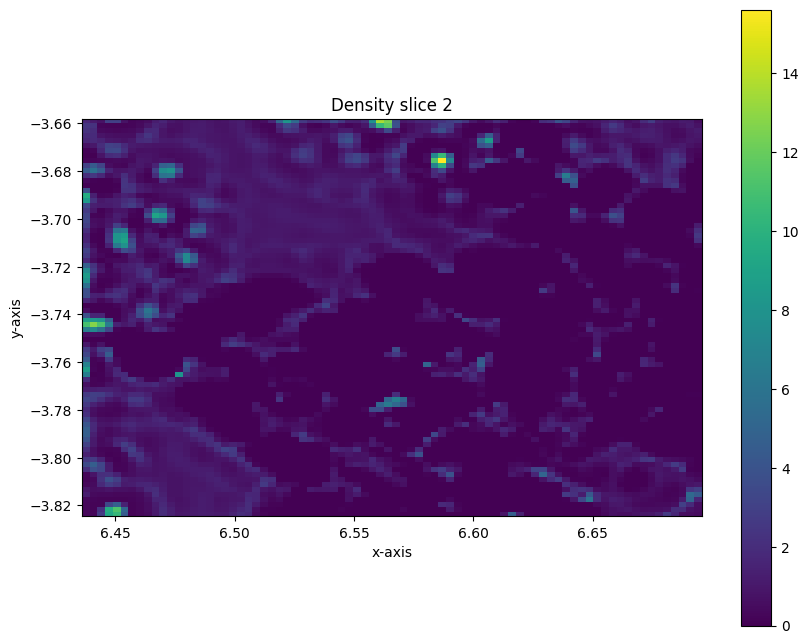

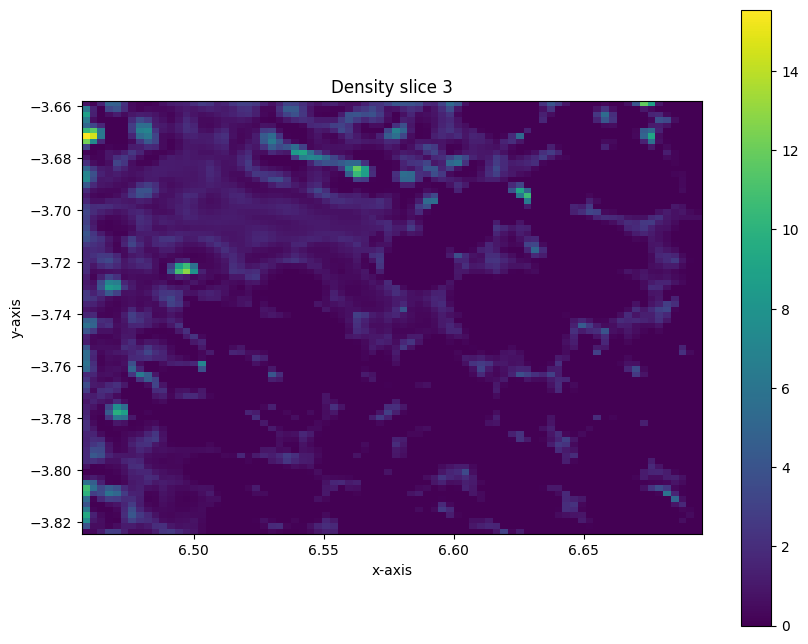

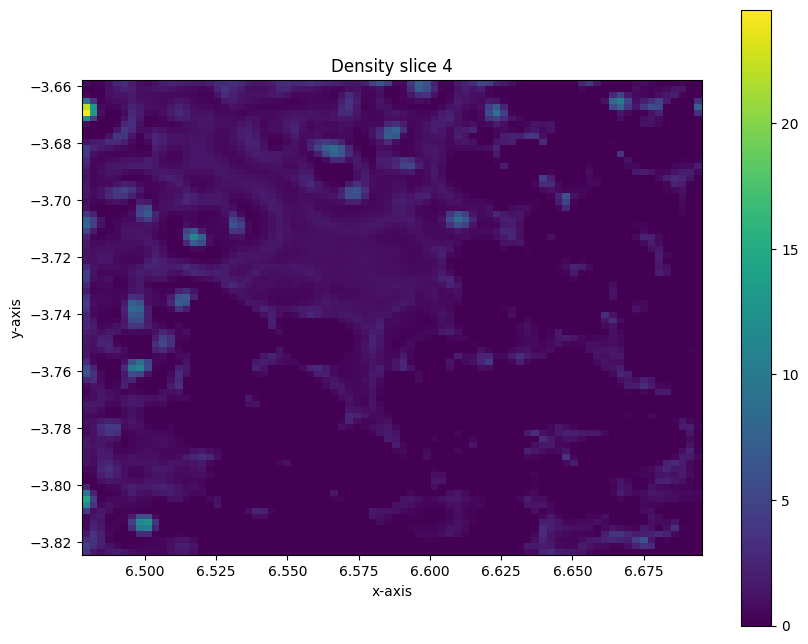

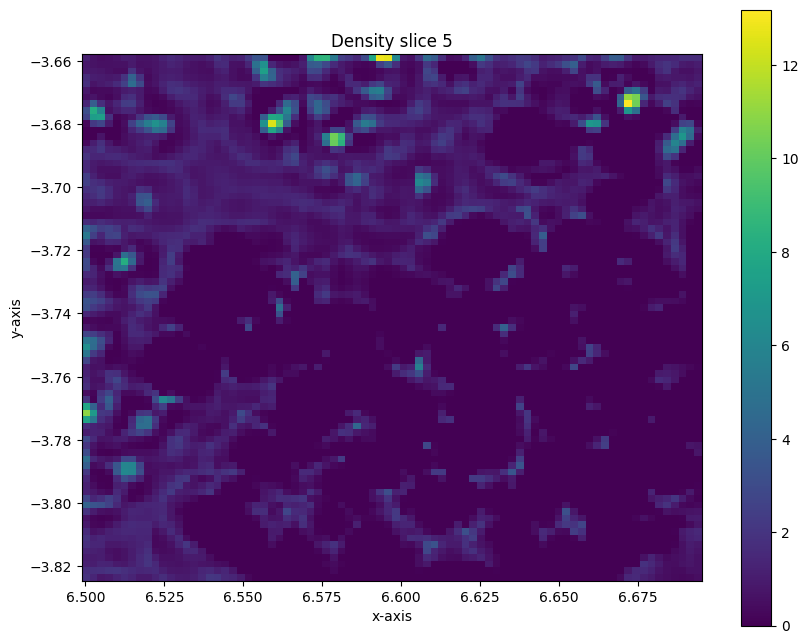

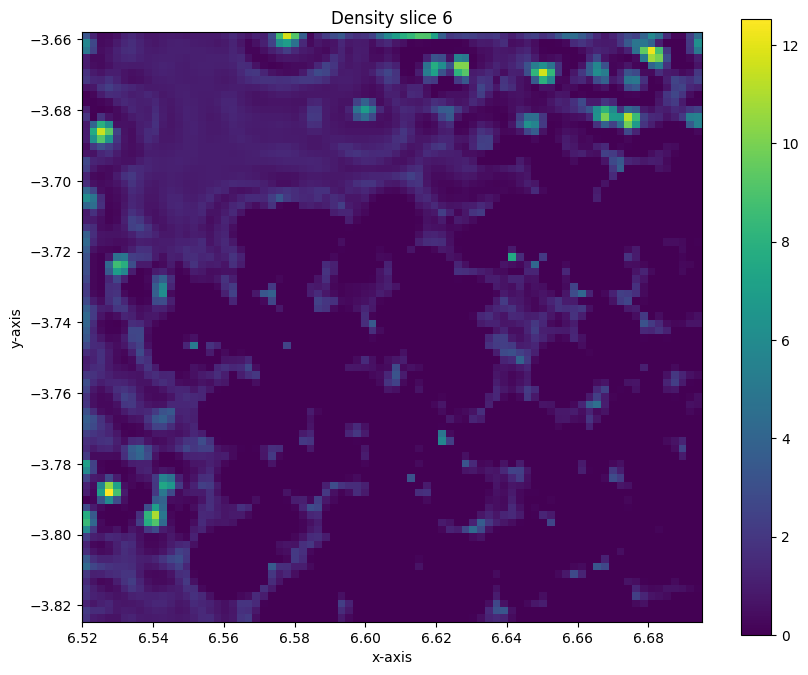

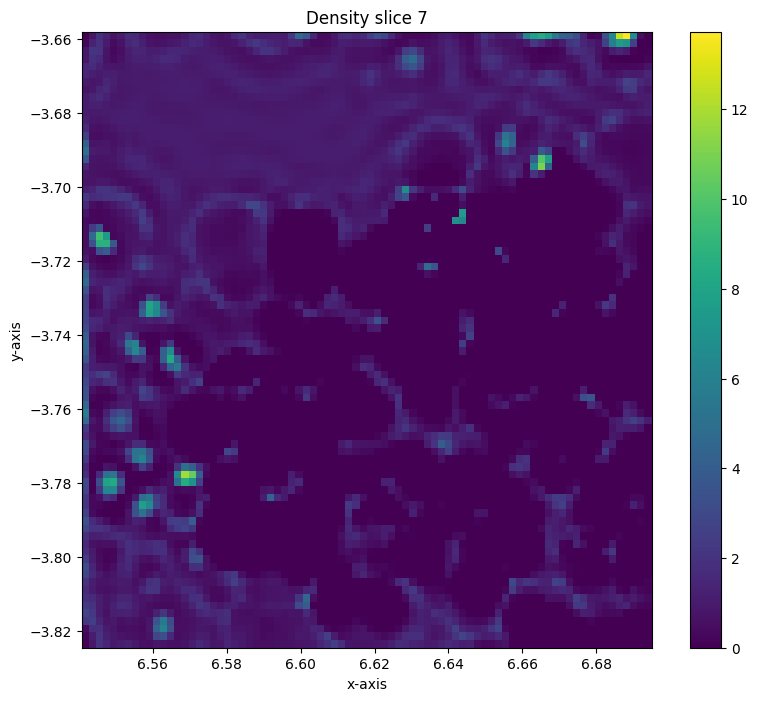

In [ ]:
for c, canvas in enumerate(canvases_bd):
    canvas.draw(title=f"Density slice {c}")

In [16]:
grid_dh = density_file_to_grid("../data/3D-RISM_densities/dehydratase/prot_3drism_dT.O.1.dx")

In [17]:
print(density_origin(grid_dh))
print(density_point_boundaries(grid_dh))

[ -9.293  -6.514 -10.821]
[30.707 33.486 29.179]


In [18]:
canvases_dh = density_slices_by_plane_and_offsets(grid, axis=np.array([1, 0, 0]), distances=np.linspace(8, 32, 4, dtype=int))

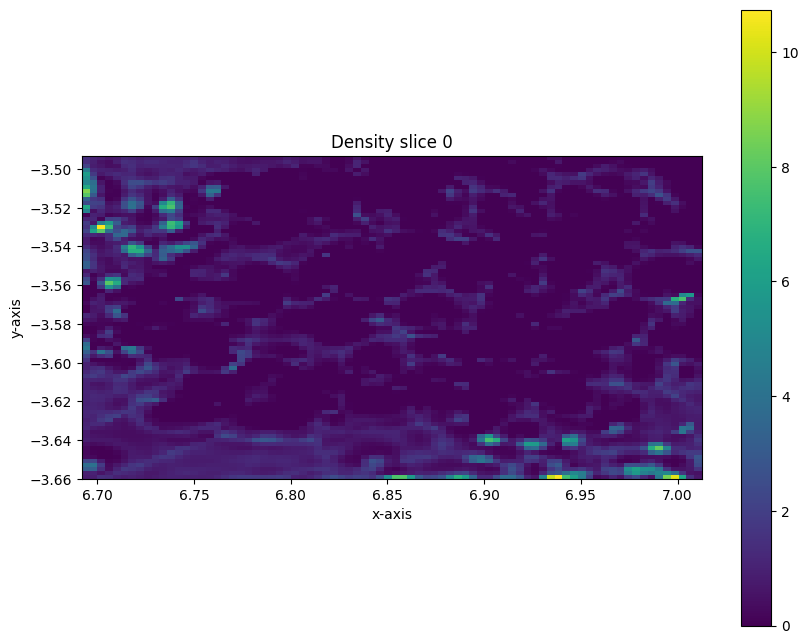

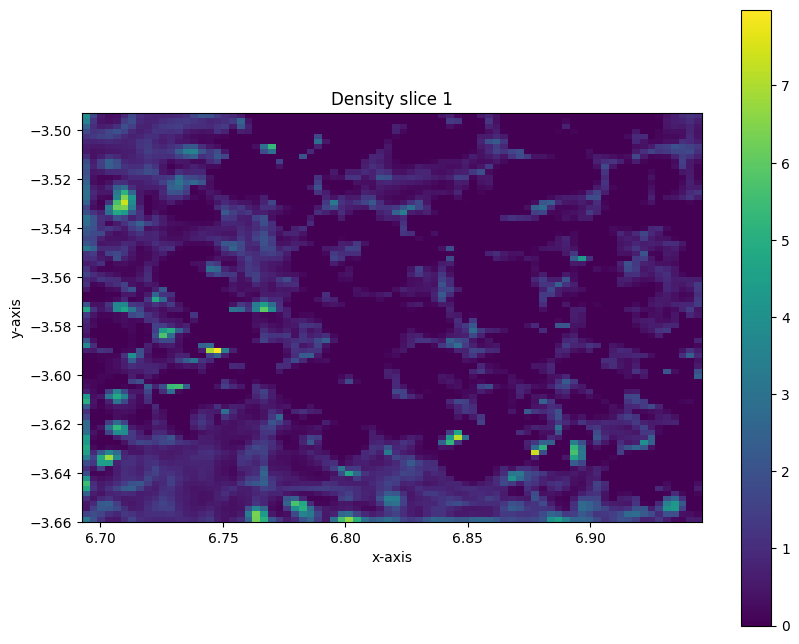

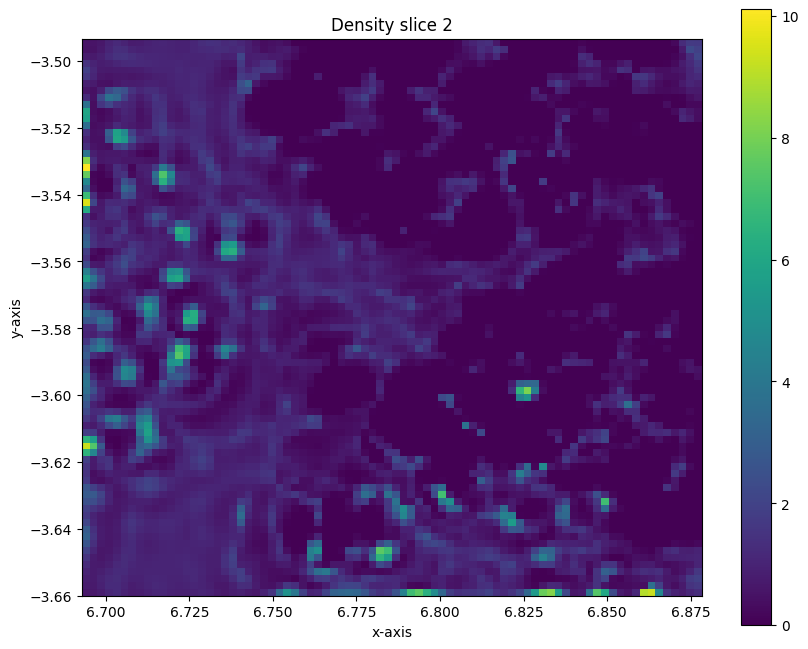

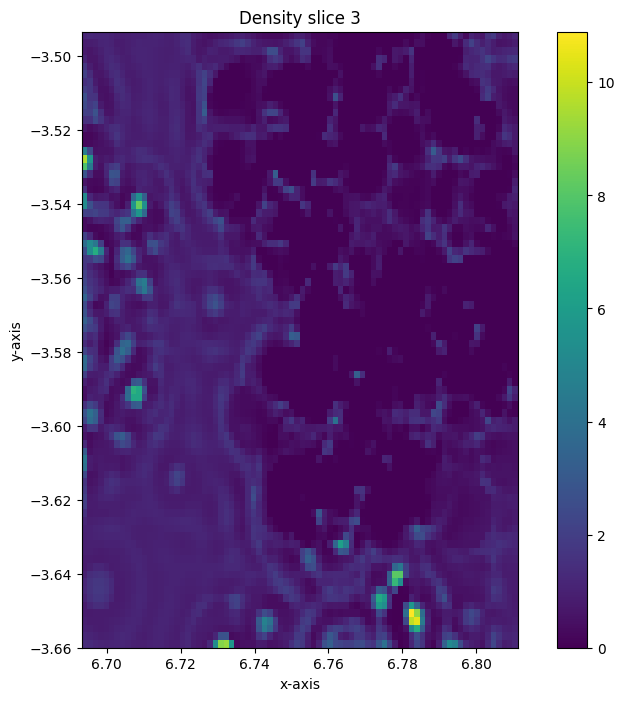

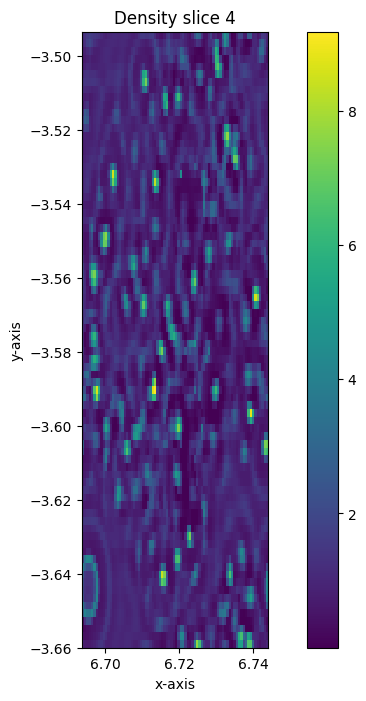

In [19]:
for c, canvas in enumerate(canvases_dh):
    canvas.draw(title=f"Density slice {c}")

In [20]:
# AQUAPOINTING

from pulser import Register
from pulser.devices import MockDevice, AnalogDevice
from pulser_simulation import QutipBackend
import pickle

from aquapointer import water_placement, processor


In [21]:
# import registers
path = "../registers/"
basename = "position_"
positions = []
registers = []
d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
for i in range(len(d_list)):
    with open(f'../registers/position_{i}.npy', 'rb') as file_in:
        pos = np.load(file_in)
    positions.append(pos)
    registers.append(Register.from_coordinates(pos)) # this is to create a Pulser register object

basename = "rescaled_position_"
rescaled_positions = []
for i in range(len(d_list)):
    with open(f'../registers/rescaled_position_{i}.npy', 'rb') as file_in:
        res_pos = np.load(file_in)
    rescaled_positions.append(res_pos)

In [22]:
# choose the maximum detuning allowed
max_det = AnalogDevice.channel_objects[0].max_abs_detuning-1

# choose a blockade radius (in micrometers)
# which in turns defines a Rabi frequency
brad = 7
omega = AnalogDevice.rabi_from_blockade(brad)

# choose a pulse duration
T = 3000

pulse_settings = processor.PulseSettings(brad=brad, omega=omega, pulse_duration=T, max_det=max_det)
processor_configs = [processor.AnalogProcessor(device=MockDevice, pos=pos, pos_id=p, pulse_settings=pulse_settings) for p, pos in enumerate(positions)]

In [23]:
def executor(pulse_seq, num_samples):
    sim = QutipBackend(pulse_seq)
    res = sim.run()
    return res.sample_final_state(num_samples)

In [ ]:
# Update once DensityCanvas integration done
test_water_postions = water_placement.find_water_positions([c._density for c in canvases], [c._centers for c in canvases], executor, processor_configs)

In [ ]:
print(test_water_postions)